# XGBoost: Hyperparameter Optimization

*   Jacob Yousif

## Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%%capture
!pip install optuna==3.6.1

In [5]:
%%capture

import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import optuna
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Process

In [7]:
npz_file_path = 'datasets/hypertuning_train_set/LearningSet.npz'
data = np.load(npz_file_path, allow_pickle=True)

In [8]:
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
features = data['feature_names']

In [9]:
features

array(['Duration', 'ProtocolCode', 'ServiceCode', 'StateCode',
       'SourcePackets', 'DestinationPackets', 'SourceBytes',
       'DestinationBytes', 'FlowRate', 'SourceTTL', 'DestinationTTL',
       'SourceLoad', 'DestinationLoad', 'SourceLoss', 'DestinationLoss',
       'SourceInterPacketTime', 'DestinationInterPacketTime',
       'SourceJitter', 'DestinationJitter', 'SourceTCPWindow',
       'SourceTCPBaseSequence', 'DestinationTCPBaseSequence',
       'DestinationTCPWindow', 'TCPRTT', 'TCPSYNACK', 'TCPACKDelta',
       'SourcePacketMeanSize', 'DestinationPacketMeanSize',
       'TransactionDepth', 'ResponseBodyLength', 'RecordServiceSource',
       'RecordStateTTL', 'RecordDestinationLTM', 'RecordSourceDPortLTM',
       'RecordDestinationSPortLTM', 'RecordDestinationSourceLTM',
       'IsFTPLogin', 'RecordFTPCommands', 'RecordFlowHTTPMethods',
       'RecordSourceLTM', 'RecordServiceDestination', 'IsSmallIPSPorts'],
      dtype='<U26')

In [10]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (113921, 42)
y_train shape: (113921,)
X_val shape: (24412, 42)
y_val shape: (24412,)


In [11]:
results = []
total = 0
best_accuracy = 0.0

In [12]:
def objective(trial):
    global total
    global results
    global best_accuracy

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'eta': trial.suggest_float('eta', 0.0, 1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.0, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
    }

    
    clf = XGBClassifier(**params, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    start_time = time.time()
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=3, verbose=False)
    duration = time.time() - start_time
    y_pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    

    total += duration

    if accuracy > best_accuracy:
        best_accuracy = accuracy

    results.append({
        'Trial': trial.number,
        'Accuracy': accuracy,
        'Duration': duration,
        'Params': params,
        'BestAccuracy': best_accuracy
    })

    return accuracy

In [13]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [14]:
seconds = int(total)
print('Total duration of the hypertuning process in seconds:', seconds, 'seconds.')

Total duration of the hypertuning process in seconds: 7117 seconds.


In [15]:
minutes = int(total / 60)
print('Total duration in minutes:', minutes, 'minutes.')

Total duration in minutes: 118 minutes.


In [16]:
hours = round(total / 3600, 1)
print('Total duration in hours:', hours, 'hours.')

Total duration in hours: 2.0 hours.


In [17]:
progress = pd.DataFrame(results)

In [18]:
progress

,Trial,Accuracy,Duration,Params,BestAccuracy
0,0,0.823816,68.174362,"{'n_estimators': 389, 'eta': 0.291893766171394...",0.823816
1,1,0.811855,19.375737,"{'n_estimators': 977, 'eta': 0.735599089954287...",0.823816
2,2,0.817876,27.915541,"{'n_estimators': 790, 'eta': 0.672134526968142...",0.823816
3,3,0.816934,109.768275,"{'n_estimators': 317, 'eta': 0.140351635071733...",0.823816
4,4,0.812551,79.306950,"{'n_estimators': 467, 'eta': 0.075578226052075...",0.823816
...,...,...,...,...,...
95,95,0.826315,48.837423,"{'n_estimators': 239, 'eta': 0.138872894676925...",0.828527
96,96,0.825987,73.920044,"{'n_estimators': 198, 'eta': 0.183511637048096...",0.828527
97,97,0.824635,53.022370,"{'n_estimators': 137, 'eta': 0.129404596327552...",0.828527
98,98,0.825700,31.365623,"{'n_estimators': 279, 'eta': 0.268624118473353...",0.828527


In [19]:
csv_file_path = 'results/XGBoostHypertuningProgress.csv'
progress.to_csv(csv_file_path, index=False)

In [20]:
best_params = study.best_params
print("Best Parameters:", best_params)

Best Parameters: {'n_estimators': 315, 'eta': 0.2085246244484748, 'max_depth': 15, 'subsample': 0.9959164354822447, 'colsample_bytree': 0.6863733553029858, 'gamma': 2.2813651119701905, 'reg_lambda': 7.320388380853057, 'reg_alpha': 3.0541829875130526, 'grow_policy': 'depthwise'}


In [21]:
xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

In [22]:
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=3, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6863733553029858, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2085246244484748,
              eval_metric='mlogloss', feature_types=None,
              gamma=2.2813651119701905, gpu_id=None, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=315, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [23]:
joblib.dump(xgb, 'models/XGBoostModel.joblib')

['models/XGBoostModel.joblib']

In [24]:
feature_importances = xgb.feature_importances_

In [25]:
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

In [26]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

In [27]:
top_n = 10
top_features = feature_importance_df.head(top_n)

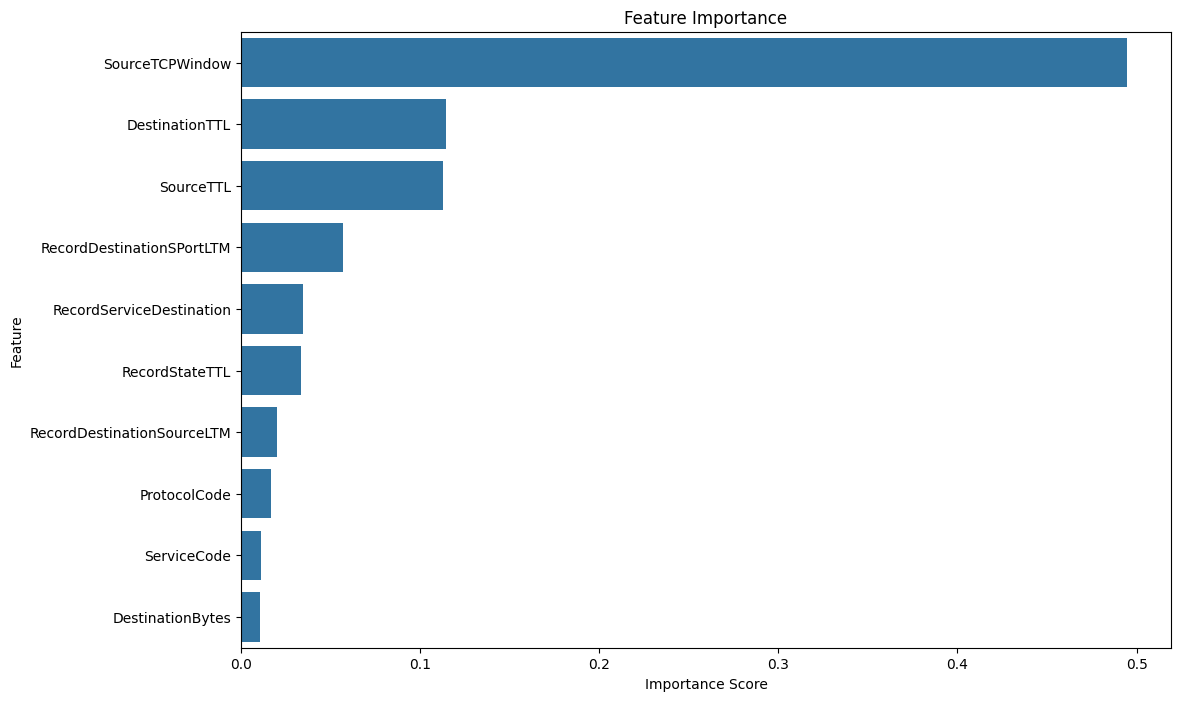

In [28]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title(f'Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.savefig('figures/features/XGBoostFeatureImportance.pdf', bbox_inches='tight')
plt.show()

In [29]:
feature_importance_df.to_csv('results/XGBoostFeatureImportance.csv', index=False)

In [30]:
feature_importance_df

,Feature,Importance
0,SourceTCPWindow,0.494512
1,DestinationTTL,0.114295
2,SourceTTL,0.112512
3,RecordDestinationSPortLTM,0.057201
4,RecordServiceDestination,0.034525
5,RecordStateTTL,0.033719
6,RecordDestinationSourceLTM,0.020213
7,ProtocolCode,0.016825
8,ServiceCode,0.011014
9,DestinationBytes,0.010399


In [31]:
feature_importance_df.columns

Index(['Feature', 'Importance'], dtype='object')